## How to generate new data with specific characteristics

In the [last notebook](https://lposti.github.io/mlpq/posts/2023-01-diffusion_intro.html) I've shown how to write from scratch a simplified diffusion model that generates quite realistic rotation curves starting from random noise. This was done by training an autoencoder to denoise rotation curves from a given database and then new curves were generated by gradually denoising pure Gaussian noise.

The limitation of the pipeline above is that we have no control on what output curve will be generated, since it all stars with random noise and the model slowly enhances some random features in the noise distribution by convincing itself that it is an underlying signal. What we would like to do now is to **guide the model to generate rotation curves with some specific characteristics** -- asymptotically flat, fast rise, slow rise, etc. -- that we decide upfront. Basically, we are asking the model to focus on and enhance those bits of random noise that kind of look like the features that we are interested in, and by using the same gradual denoising procedure based on small *timesteps* the algorithm will be able to further refine them and to finally construct a realistic dataset with some given charateristics.

In [1]:
#| code-fold: true
import numpy as np
import matplotlib.pylab as plt
from scipy.special import i0, i1, k0, k1
from torch import tensor
from torch import nn
from torch.nn import functional as F
import torch, math
import random

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

## Data generation

Let's start by generating a rotation curve dataset. This step is borrowed from the blog post [intro to diffusion models](https://lposti.github.io/mlpq/posts/2023-01-diffusion_intro.html) and I use the same methodology and the same code. However, to spice things up a bit, here I introduce another mass component to the galaxy rotation curves which is the bulge. Thus, I have a new mass--size relation for bulges that I use to sample the parameter space and I add the circular velocity of a Hernquist bulge into the calculation of the rotation curves.

Galaxies with significantly different mass and size ratios of the disc and bulge components have quite different rotation curves, with distinct recognizeable features -- e.g. high bulge-fraction galaxies have rotation curves that rise very steeply, have central peak, and then decline fast, while those with low bulge fraction have a slowly rising curve. The goal of this notebook is then to train a model that can generate rotation curves that have some of these specific features that we can specify upfront.

In [2]:
#| code-fold: true
G, H, Dc = 4.301e-9, 70, 200.

def fc(x):
    return np.log(1+x)-x/(1+x)

def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

In [13]:
# halo concentration--mass relation
def c(Mh, w_scatter=False, H=70.): 
    if w_scatter: return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12) + rng.normal(0.0, 0.11, len(Mh)))
    return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12))

# disc mass--size relation
def getRd_fromMd(Md, w_scatter=False):
    ''' approximate mass-size relation '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.3+0.5 + rng.normal(0.0, 0.4, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.3+0.5)

# stellar mass--halo mass relation
def getMh_fromMs(Ms, w_scatter=False):
    ''' approximate SHMR '''
    if w_scatter: return 10**((np.log10(Ms)-10.7)*0.75+12.0 + rng.normal(0.0, 0.25, len(Ms)))
    return 10**((np.log10(Ms)-10.7)*0.75+12.0)

# bulge mass--size relation
def getRb_fromMb(Mb, w_scatter=False):
    ''' approximate mass-size relation '''
    if w_scatter: return 10**((np.log10(Mb)-10.7)*0.3+0.5 + rng.normal(0.0, 0.4, len(Mb)))
    return 10**((np.log10(Mb)-10.7)*0.55+0.55)

I need to introduce two more free parameters, the mass and size of the bulge, to generate a galaxy model now. While I sample both disc and bulge masses from uniform distributions, I take the bulge size to lie on a given scaling relation, in analogy to what I've done for the disc component.

In [15]:
nsamp = 5000
md = 10**rng.uniform(9, 12, nsamp)
mb = 10**rng.uniform(9, 12, nsamp)
ms = md+mb
rd = getRd_fromMd(md, w_scatter=True)
rb = getRb_fromMb(mb, w_scatter=True)
mh = getMh_fromMs(ms, w_scatter=True)
cc = c(mh, w_scatter=True)

In [99]:
class curveMod():
    def __init__(self, Md, Rd, Mb, Rb, Mh, cc, rad=np.logspace(-1, np.log10(50), 50)):
        self.G, self.H, self.Dc = 4.301e-9, 70, 200.  # physical constants
        self.Md, self.Rd = Md, Rd
        self.Mb, self.Rb = Mb, Rb
        self.Mh, self.cc = Mh, cc
        self.rad = rad
        
        if hasattr(self.Md, '__len__'):
            self.vdisc  = [self._vdisc(self.rad,  self.Md[i], self.Rd[i]) for i in range(len(self.Md))]
            self.vbulge = [self._vbulge(self.rad, self.Mb[i], self.Rb[i]) for i in range(len(self.Md))]
            self.vdm    = [self._vhalo(self.rad,  self.Mh[i], self.cc[i]) for i in range(len(self.Md))]
            self.vc     = [np.sqrt(self.vdisc[i]**2+self.vbulge[i]**2+self.vdm[i]**2) for i in range(len(self.Md))]
        else:
            self.vdisc  = self._vdisc(self.rad,  self.Md, self.Rd)
            self.vbulge = self._vbulge(self.rad, self.Mb, self.Rb)
            self.vdm    = self._vhalo(self.rad,  self.Mh, self.cc)
            self.vc     = np.sqrt(self.vdisc**2+self.vbulge**2+self.vdm**2)
        
    def _fc(self, x): return np.log(1+x)-x/(1+x)
    def _Vvir(self, Mh): return np.sqrt((self.Dc*(self.H)**2/2)**(1./3.) * (self.G*Mh)**(2./3.))
    def _Rvir(self, Mh): return 1e3 * (Mh / (0.5*self.Dc*self.H**2 /self.G))**(1./3.)
    
    def _vhalo(self, R, Mh, cc):
        # circular velocity of the halo component (NFW model)
        rv = self._Rvir(Mh)
        return np.sqrt(self._Vvir(Mh)**2*rv/R*self._fc(cc*R/rv)/self._fc(cc)) 
    
    def _vdisc(self, R, Md, Rd):
        # circular velocity of the disc component (exponential disc)
        y = R/2./Rd
        return np.nan_to_num(np.sqrt(2*4.301e-6*Md/Rd*y**2*(i0(y)*k0(y)-i1(y)*k1(y))))
    
    def _vbulge(self, R, Mb, Rb):
        # circular velocity of the bulge component (Hernquist bulge)
        return np.sqrt(G*1e3*Mb*R)/(R+Rb)

In [100]:
cm=curveMod(md,rd,mb,rb,mh,cc)

Finally we can plot some of these rotation curves:

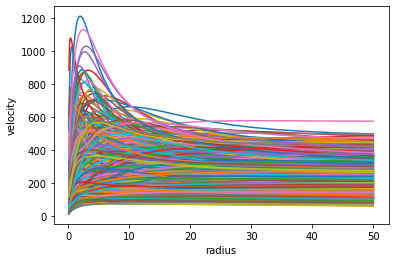

In [101]:
for i,v in enumerate(cm.vc): 
    if i%10==0: plt.plot(cm.rad, v)
plt.xlabel('radius')
plt.ylabel('velocity');

Even though it does not appear clearly from the plot above, the rotation curves in this database are much more varied, and have shapes that are wildly more different, with respect to the database without bulges that I used in the previous intro post on diffusion models.

### Normalization and train/valid splitting

As always, it is important to normalize and shuffle the data and to create a traning/validation split.

In [103]:
def datanorm(x):  return (x-x.mean())/x.std(), x.mean(), x.std()
def datascale(x, m, s): return x*s+m

idshuff = torch.randperm(nsamp)
xdata = tensor(cm.vc, dtype=torch.float)[idshuff,:]
xdata, xmean, xstd = datanorm(xdata)

fval = 0.20
xtrain = xdata[:int(nsamp*(1.0-fval))]
xvalid = xdata[int(nsamp*(1.0-fval)):]

## Adding noise

The noise scheduler is exactly the same as in the previous post, just to keep things as simple as possible.

In [212]:
def add_noise(x, a):
    noise = torch.randn_like(x)
    if a.shape != torch.Size([]): a = a.view(-1, 1)
    return x*(1-a) + noise*a

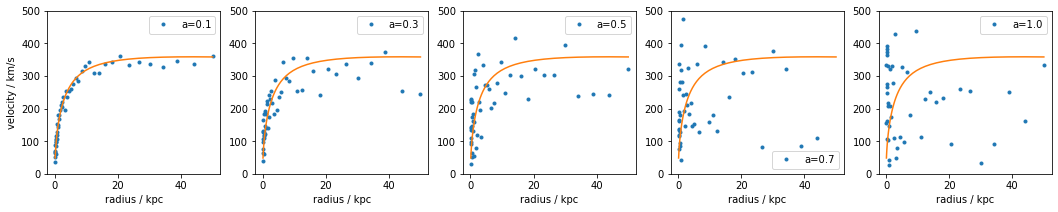

In [214]:
fig,ax=plt.subplots(figsize=(18,3),ncols=5)

def commons(ax, a):
    ax.plot(cm.rad, datascale(add_noise(xtrain[1],tensor(a)), xmean, xstd), '.', label='a=%1.1f' % a)
    ax.plot(cm.rad, datascale(xtrain[1], xmean, xstd))
    ax.set_xlabel('radius / kpc')
    ax.legend()
    ax.set_ylim(0,500)

commons(ax[0], 0.1)
ax[0].set_ylabel('velocity / km/s')
commons(ax[1], 0.3)
commons(ax[2], 0.5)
commons(ax[3], 0.7)
commons(ax[4], 1.0)

## Conditioned Autoencoder model

To include conditioning in the autoencoder network I do not necessarily need to vary a lot the model and I can get away with just some minimal modifications. This is not exactly what state-of-the-art diffusion models really do (using CLIPs and embeddings), but it is identical in spirit and it is much simpler to write and understand.

The basic idea is to pass as input of the autoencoder not only the thing we want to reproduce (in this case the rotation curve tensor) but also a tensor of properties of the input. This can be a simple array of numbers, as in this case, or a more complicated embedding layer, but the principle is that the autoencoder is given a priori some additional information that further characterize the input. Once the model is trained, it has learned to recognize these additional properties, thus when it will have to generate a new input from pure noise it will be able to use this additional tensor of properties to condition and guide its denoising process.

### Conditioning tensors

I select four properties that I use as conditioning: the bulge over stellar mass ratio, the stellar over halo mass ratio, the disc over bulge size ratio, and the stellar mass. While the latter specifies the absolute scale of the galaxy, the other three are relative parameters that are able to constrain the shape of the rotation curve relatively well.

In [215]:
cond_train = tensor([mb/ms, np.log10(ms/mh), 
                     np.log10(rd/rb), np.log10(ms)])[:, idshuff[:int(nsamp*(1.0-fval))]].T.float()
cond_valid = tensor([mb/ms, np.log10(ms/mh), 
                     np.log10(rd/rb), np.log10(ms)])[:, idshuff[int(nsamp*(1.0-fval)):]].T.float()

This tensor will be concatenated to the input, i.e. the rotation curve tensor, to feed the autoencoder.

### Model

In [177]:
class AE_cond_net(nn.Module):
    def __init__(self, ninp, ncond=4, **kwargs):
        super().__init__()
        self.encoder_layers = nn.ModuleList([
            nn.Linear(in_features=ninp+ncond, out_features=32),
            nn.Linear(in_features=32,         out_features=16),
            nn.Linear(in_features=16,         out_features=4)
        ])
        self.decoder_layers = nn.ModuleList([
            nn.Linear(in_features=4,    out_features=16),
            nn.Linear(in_features=16,   out_features=32),
            nn.Linear(in_features=32,   out_features=ninp)
        ])
        self.act = nn.SiLU() # The activation function
        
            
    def forward(self, x, cond):
        
        h = [] # skip connections
        
        for i, l in enumerate(self.encoder_layers):
            x = self.act(l(x)) if i>0 else self.act(l(torch.cat((x, cond), 1))) # collate x and cond in the 1st layer
            if i < 2: h.append(x) # store for skip connection, for all but final layer
              
        for i, l in enumerate(self.decoder_layers):
            if i > 0: x += h.pop() # get stored output for skip connection, for all but first layer
            x = self.act(l(x)) if i<2 else l(x) # final layer without activation
            
        return x

This model is quite similar to the unconditioned autoencoder that I used for the previous blog post, with just the first layer being different as now it takes four more inputs.

In [179]:
model = AE_cond_net(len(cm.rad))

In [180]:
# Adam and MSE Loss
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(2001):
    
    # generate random noise amount
    noise = torch.rand(xtrain.shape[0])
    
    # add noise to data
    x_noisy = add_noise(xtrain, noise)
    
    # prediction
    ymod = model.forward(x_noisy, cond_train)
    
    # loss
    loss = loss_func(xtrain, ymod)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%100==0: print(epoch, 
                           "train L:%1.2e"   % loss, 
                           "  valid L:%1.2e" % loss_func(xvalid, model.forward(xvalid, cond_valid)))

0 train L:1.12e+00   valid L:8.95e-01
100 train L:1.75e-01   valid L:8.12e-02
200 train L:1.30e-01   valid L:4.16e-02
300 train L:1.11e-01   valid L:4.08e-02
400 train L:1.16e-01   valid L:3.14e-02
500 train L:1.12e-01   valid L:2.67e-02
600 train L:1.49e-01   valid L:3.10e-02
700 train L:1.06e-01   valid L:7.43e-02
800 train L:8.87e-02   valid L:4.36e-02
900 train L:1.05e-01   valid L:8.58e-02
1000 train L:9.61e-02   valid L:2.50e-02
1100 train L:1.02e-01   valid L:4.59e-02
1200 train L:9.14e-02   valid L:4.38e-02
1300 train L:1.07e-01   valid L:5.09e-02
1400 train L:9.99e-02   valid L:1.62e-02
1500 train L:9.19e-02   valid L:1.99e-02
1600 train L:8.79e-02   valid L:2.06e-02
1700 train L:9.56e-02   valid L:3.83e-02
1800 train L:9.37e-02   valid L:2.37e-02
1900 train L:9.59e-02   valid L:5.43e-02
2000 train L:9.33e-02   valid L:2.87e-02


## Generating new conditioned data

Now that the model has trained let's use the sampling technique that we developed for the previous notebook to generate some new data. This is the pipeline that gradually denoises an input that is fully Gaussian random noise, but this time we can ask the model to **condition** this denoising procedure with a feature vector that we pass it.

Let's start from the conditioning tensor: let's go for a high bulge fraction, dark matter dominated, small galaxy:

In [227]:
conds = tensor([0.9,  -1.2, 0.8, 10.0]).unsqueeze(0)

In [228]:
nsteps = 31    
x_ini = torch.randn_like(xtrain[0].unsqueeze(0))
inputs  = []
outputs = []

for i in range(nsteps):
    with torch.no_grad():
        ymod = model(x_ini, conds)
        
    if i%10==0:
        inputs.append(x_ini)
        outputs.append(ymod) 
        
    mix_factor = 1/(nsteps - i)                    # how much denoising we apply
    x_ini = x_ini*(1-mix_factor) + ymod*mix_factor # mix noisy input with model prediction
    
inputs  = torch.stack(inputs)
outputs = torch.stack(outputs)

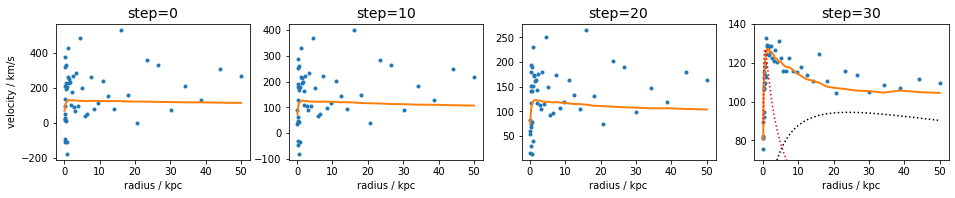

In [279]:
fig, ax = plt.subplots(figsize=(16,2.5), ncols=inputs.shape[0])

for j in range(inputs.shape[0]):
    ax[j].plot(cm.rad, datascale(inputs[j,0], xmean, xstd), '.')
    ax[j].plot(cm.rad, datascale(outputs[j,0], xmean, xstd), '-', lw=2)
    ax[j].set_title('step=%d' % (j*10), fontsize=14)
    ax[j].set_xlabel('radius / kpc')
    
c1 = curveMod(3e9,4.0,9e9,0.6,1.6e11,10.0)
ax[-1].plot(cm.rad, c1.vbulge, 'r:')
ax[-1].plot(cm.rad, c1.vdm, 'k:')
ax[-1].set_ylim(70,140)
ax[0].set_ylabel('velocity / km/s');

Fantastic!

We have successfully created a model that takes as input four numbers, that specify some properties of a galaxy, and it returns as output a realistic rotation curve for that galaxy. The gradual denoising pipeline that we used here is great since it allows us to simply try with another initial random tensor and we will get out a different rotation curve, but with the same features that we specified. This is useful to generate multiple instances of the same galaxy type.

Naturally, we can readily generate new samples of all sorts of galaxy rotation curve types.

In [209]:
conds = tensor([[0.9,  -1.2, 0.8, 10.0],
                [0.01, -1.2, 1.0, 10.5],
                [0.5,  -1.2, -1.0, 10.7],
                [0.01, -0.3, 0.5, 11.7],
                [0.9,  -0.3, 1.5, 11.5]])

In [210]:
nsteps = 31    
x_ini = torch.randn_like(xtrain[:5])
inputs  = []
outputs = []

for i in range(nsteps):
    with torch.no_grad():
        ymod = model(x_ini, conds)
        
    if i%10==0:
        inputs.append(x_ini)
        outputs.append(ymod) 
        
    mix_factor = 1/(nsteps - i)                    # how much denoising we apply
    x_ini = x_ini*(1-mix_factor) + ymod*mix_factor # mix noisy input with model prediction
    
inputs  = torch.stack(inputs)
outputs = torch.stack(outputs)

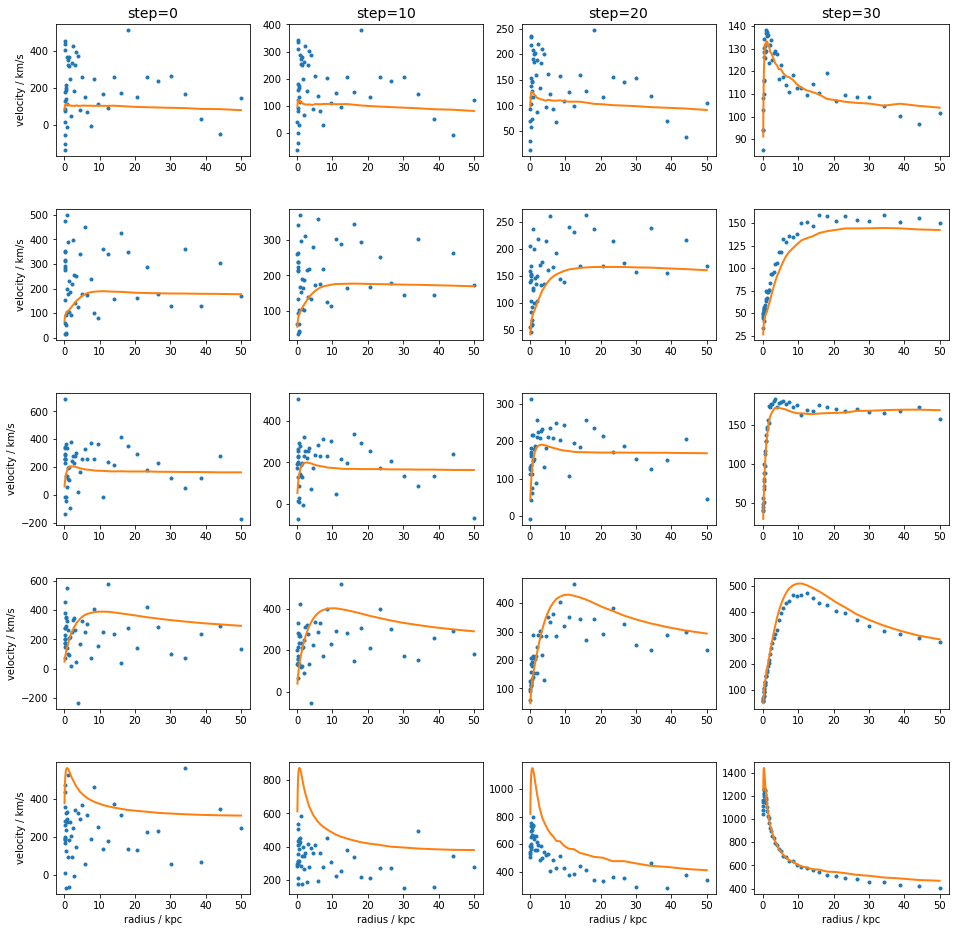

In [211]:
fig, ax = plt.subplots(figsize=(16,16), nrows=inputs.shape[1], ncols=inputs.shape[0], gridspec_kw={'hspace':0.4})

for i in range(inputs.shape[1]):
    for j in range(inputs.shape[0]):
        ax[i,j].plot(cm.rad, datascale(inputs[j,i], xmean, xstd), '.')
        ax[i,j].plot(cm.rad, datascale(outputs[j,i], xmean, xstd), '-', lw=2)
                
        if j == 0: ax[i,j].set_ylabel('velocity / km/s')
        if i == inputs.shape[1]-1: ax[i,j].set_xlabel('radius / kpc')
        if i == 0: ax[i,j].set_title('step=%d' % (j*10), fontsize=14)